In [8]:
!git clone https://github.com/s-kganz/terrain_autoencoder.github
!pip install -q pytorch-lightning rioxarray planetary_computer stackstac folium matplotlib mapclassify
!pip install -q git+https://github.com/s-kganz/xbatcher.git@patch_filter_resample

fatal: destination path 'terrain_autoencoder' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [23]:
import os
os.chdir("terrain_autoencoder")

# DL stuff
import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Geospatial stuff
import shapely
import pandas as pd
import geopandas as gpd
import pystac_client
import stackstac
import planetary_computer
import xarray as xr
import xbatcher
import rioxarray
import numpy as np

## Get data

We will start by pulling a segment of NASADEM for Washington's Olympic peninsula.

In [11]:
# Define extent
box = gpd.GeoSeries(shapely.geometry.box(-124.461365,47.221434,-122.986450,48.123934), crs=4326)

In [12]:
# Query for granules
stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

items = stac.search(
    bbox=box.total_bounds,
    collections=["nasadem"],
).item_collection()

print(f"Found {len(items)} items")

Found 6 items


In [13]:
# Where are they?
footprints = gpd.GeoSeries(map(lambda x: shapely.geometry.shape(x.geometry), items), crs=4326)
footprints = gpd.GeoDataFrame(data={"idx": list(range(len(footprints)))}, geometry=footprints)

m = box.explore()
m = footprints.explore(m=m, color="red", attr="idx")

m

In [14]:
# Fourth one looks good
items[4]

<Item id=NASADEM_HGT_n47w124>

In [15]:
# One tile is pretty small so we can happily bring it into memory
dem = stackstac.stack(
    [items[4]],
    assets=["elevation"],
    epsg=4326
).squeeze(drop=True).compute()
# Rescale to 0-1
dem = (dem - dem.min()) / (dem.max() - dem.min())
dem

<xarray.DataArray 'stackstac-dc262df687eb29cb2b57c2aab994d6b4' (y: 3602, x: 3602)> Size: 104MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.23248007, 0.2370961 , ..., 0.11456148, 0.11624003,
        0.11833823],
       [       nan, 0.23373898, 0.23961393, ..., 0.11749895, 0.12043642,
        0.12253462],
       ...,
       [       nan, 0.00671423, 0.00713386, ..., 0.0365086 , 0.03608896,
        0.03524969],
       [       nan, 0.00671423, 0.00713386, ..., 0.03734788, 0.03734788,
        0.03692824],
       [       nan, 0.00713386, 0.0075535 , ..., 0.03776752, 0.0386068 ,
        0.03776752]])
Coordinates:
  * x               (x) float64 29kB -124.0 -124.0 -124.0 ... -123.0 -123.0
  * y               (y) float64 29kB 48.0 48.0 48.0 48.0 ... 47.0 47.0 47.0 47.0
    proj:shape      object 8B {3601}
    proj:code       <U9 36B 'EPSG:4326'
    proj:transform  object 8B {0.0, 1.0, -124.00013888888888, -0.000277777777...
    proj:bbox       object 8B {48.00013888888889, 46.999861111111116, -124.00...
    title           <U9 36B 'Elevation'
    epsg            int64 8B 4326

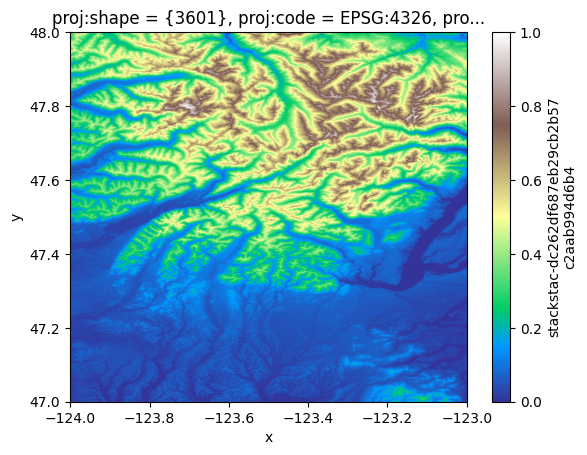

In [16]:
dem.plot.imshow(vmin=0, cmap="terrain")

## Make dataloader

Here we use xbatcher to slice the terrain into patches of 32x32 pixels. Suppose we want to discard patches in lowlands. We can do so by only retaining patches with mean greater than 0.25.

In [17]:
def patch_filter(ds, selector):
    return ds.isel(**selector).values.mean() > 0.25

patch_size_x = 32
patch_size_y = 32

bgen = xbatcher.BatchGenerator(
    dem,
    input_dims=dict(x=patch_size_x, y=patch_size_y),
    input_overlap=dict(x=8, y=8),
    filter_fn=patch_filter
)

print(len(bgen))
print(bgen[0].shape)

9824
(32, 32)


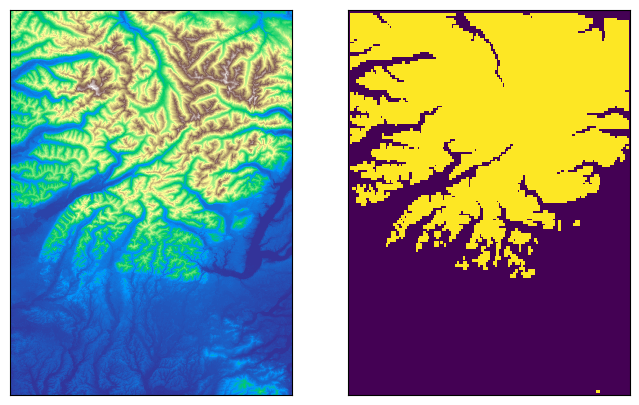

In [18]:
# Visualize where the patches are
arr = xr.DataArray(
    data=np.zeros(dem.shape),
    dims=dem.sizes.keys(),
)

for i, batch in enumerate(bgen):
    indexer = bgen._batch_selectors.selectors[i][0]
    arr.loc[indexer] = 1

arr = arr.assign_coords(dem.coords)

fig, (left, right) = plt.subplots(1, 2, figsize=(8, 5))
dem.plot.imshow(vmin=0, cmap="terrain", ax=left, add_labels=False, add_colorbar=False, xticks=[], yticks=[])
left.set_title("")
arr.plot.imshow(ax=right, add_labels=False, add_colorbar=False, xticks=[], yticks=[])

## Model training

This section is optional, the relevant xbatcher functions happen afterward.

In [19]:
# Convert the batch generator to a torch dataloader
class BatchGenDataset(torch.utils.data.Dataset):
    def __init__(self, bgen):
        self.bgen = bgen

    def __len__(self):
        return len(self.bgen)

    def __getitem__(self, idx):
        # replace nans with 0
        patch = torch.tensor(self.bgen[idx].values)
        patch = torch.nan_to_num(patch)
        # add a singleton channel dim
        patch = torch.unsqueeze(patch, 0)
        # convert datatype
        patch = patch.float()
        return patch

ds = BatchGenDataset(bgen)
loader = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True)
print(next(iter(loader)).shape)

torch.Size([16, 1, 32, 32])


We also need a validation set. A natural choice is just an adjacent granule.

In [20]:
%%time
def item_to_dataloader(stac_item, **loader_args):
    arr = stackstac.stack(
        [stac_item],
        assets=["elevation"],
        epsg=4326
    ).squeeze(drop=True).compute()

    # Rescale from 0-1
    arr = (arr - arr.min()) / (arr.max() - arr.min())

    bgen = xbatcher.BatchGenerator(arr, input_dims=dict(x=patch_size_x, y=patch_size_y), input_overlap=dict(x=8, y=8), filter_fn=patch_filter)
    ds = BatchGenDataset(bgen)
    loader = torch.utils.data.DataLoader(ds, **loader_args)

    return loader

train_loader = item_to_dataloader(items[4], batch_size=16, shuffle=True)
print("Batches in training:", len(train_loader))
val_loader   = item_to_dataloader(items[0], batch_size=16, shuffle=False)
print("Batches in validation:", len(val_loader))

Batches in training: 614
Batches in validation: 415
CPU times: user 7.94 s, sys: 553 ms, total: 8.49 s
Wall time: 15.1 s


### Define model
This is coming straight out of [this tutorial](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html#Setup) notebook on deep autoencoders.

In [25]:
import autoencoder
from importlib import reload
reload(autoencoder)

<module 'autoencoder' from '/content/terrain_autoencoder/autoencoder.py'>

In [26]:
a_batch = next(iter(train_loader))
enc = autoencoder.Autoencoder(num_input_channels=1, base_channel_size=32, latent_dim=128)
assert(enc(a_batch).shape == a_batch.shape) # check that output shape matches input

### Train function


In [27]:
def train_autoencoder(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=10,
        limit_val_batches=10
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    model = autoencoder.Autoencoder(num_input_channels=1, base_channel_size=16, latent_dim=latent_dim, width=patch_size_x, height=patch_size_y)
    trainer.fit(model, train_loader, val_loader)
    result = trainer.test(model, dataloaders=val_loader)
    return trainer, model, result


In [28]:
trainer, model, result = train_autoencoder(128)
# model = Autoencoder.load_from_checkpoint("path/to_checkpoint")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode  | In sizes       | Out sizes     
------------------------------------------------------------------------------
0 | encoder | Encoder | 91.3 K | train | [2, 1, 32, 32] | [2, 128]      
1 | decoder | Decoder | 91.6 K | train | [2, 128]       | [2, 1, 32, 32]
------------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.09215216338634491    │
└───────────────────────────┴───────────────────────────┘

## View reconstructions

In [29]:
# If you didn't run the training section, you can load the model from a checkpoint
# model = autoencoder.Autoencoder.load_from_checkpoint("lightning_logs/version_10/checkpoints/epoch=9-step=13880.ckpt").to("cpu")

In [30]:
# Only take the first n samples from the batch
n = 4
batch = next(iter(val_loader))[:n, ...]
model.eval()
out = model(batch)

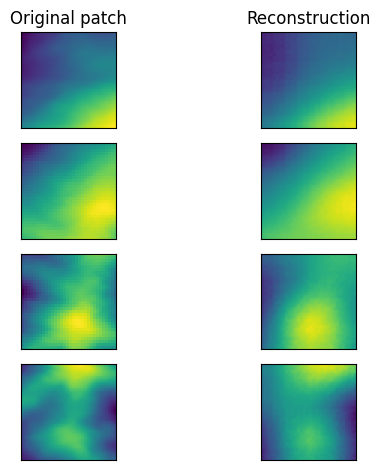

In [31]:
fig, axes = plt.subplots(n, 2)

imshow_args = dict(cmap="viridis")

for i in range(n):
    original = batch[i, ...].squeeze().detach().numpy()
    reconst  = out[i, ...].squeeze().detach().numpy()

    min_, max_ = np.min(original), np.max(original)
    axes[i, 0].imshow(original, vmin=min_, vmax=max_, **imshow_args)
    axes[i, 0].set_yticks([])
    axes[i, 0].set_xticks([])
    axes[i, 1].imshow(reconst, vmin=min_, vmax=max_, **imshow_args)
    axes[i, 1].set_yticks([])
    axes[i, 1].set_xticks([])

axes[0, 0].set_title("Original patch")
axes[0, 1].set_title("Reconstruction")
fig.tight_layout()
plt.show()

## Assemble model output into a new data array

Now suppose we want to transform our network output into a data array that we can visualize. We need to run each patch through the network and reassmble them while accounting for overlaps. If we were to do this manually, you might imagine a complicated for loop structure like so.

In [32]:
output_array = np.zeros(dem.shape)
output_n     = np.zeros(dem.shape)

for x_start in range(0, dem.shape[0]-patch_size_x, patch_size_x):
    for y_start in range(0, dem.shape[1]-patch_size_y, patch_size_y):
        inp = torch.tensor(dem.data[y_start:y_start+patch_size_y, x_start:x_start+patch_size_x])
        inp = torch.nan_to_num(inp).unsqueeze(0).unsqueeze(0).float()
        out = model(inp).detach().numpy()

        output_array[y_start:y_start+patch_size_y, x_start:x_start+patch_size_x] += out[0, 0, ...]
        output_n[y_start:y_start+patch_size_y, x_start:x_start+patch_size_x] += 1

/tmp/ipython-input-33-1825508455.py:2: RuntimeWarning: invalid value encountered in divide
  output_avg = output_array / output_n


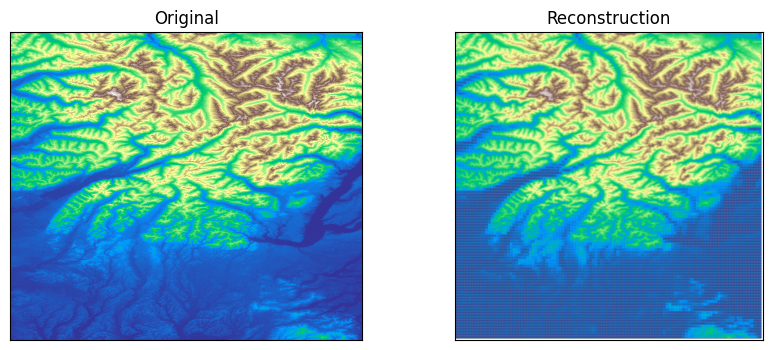

In [33]:
# Simple average in pixels where windows overlap
output_avg = output_array / output_n

fig, (left, right) = plt.subplots(1, 2, figsize=(10, 4))

right.imshow(output_avg, vmin=0, vmax=1, cmap="terrain")
right.set_xticks([])
right.set_yticks([])
right.set_title("Reconstruction")

dem.plot(ax=left, cmap="terrain", add_labels=False, add_colorbar=False, xticks=[], yticks=[], vmin=0, vmax=1)
left.set_title("Original")

plt.show()

This is error prone and difficult to modify for other use cases. What if the output tensor has a new dimension, or no longer has a dimension in the original array? We can simplify this task by utilizing the windowing information already contained in the batch generator. To do so we need a few hints about the output tensors the model will generate. Each output tensor dimension, except for the batch dimension, must satisfy one of the following conditions.

 - Be a new dimension not in the original data array
 - Have size equal to the window used by the batch generator
 - Have size equal to 1, in which case the tensor is broadcast

Suppose we want to access the 128-dimensional latent vector in the encoder step of the above autoencoder. If we pass a single patch into the encoder, what output shape do we get?

In [34]:
my_patch = train_loader.dataset[0].unsqueeze(0)
print("Input patch:", my_patch.shape)
out = model.encoder(my_patch)
print("Encoded tensor:", out.shape)

Input patch: torch.Size([1, 1, 32, 32])
Encoded tensor: torch.Size([1, 128])


The resulting shape is (1, 128). We ignore the first (batch) dimension, and the second dimension is not in the original data array. So, we should be able to combine these results into a data array. We will only do this demo on a portion of the overall DEM since a float array of shape (3600, 3600, 128) takes up 13 GB.

In [35]:
from tqdm.autonotebook import tqdm

def assemble_model_output(dataset, model, tensor_shape):
    # Output array has union of bgen input dimensions and tensor dimensions.
    # If a dim is in the bgen input, the output array will have the same size
    # as the input array at that dimensions. Otherwise, the output array
    # will have the same size as the tensor at that dimension.
    # Dimensions must have the same order as the tensor for broadcasting to
    # work.
    bgen = dataset.X_generator
    output_da_dims = list(tensor_shape.keys())
    for input_dim in bgen.input_dims.keys():
        if input_dim not in output_da_dims: output_da_dims.append(input_dim)

    output_da_size = tuple(
        bgen.ds.sizes[d] if d in bgen.input_dims else tensor_shape[d]
        for d in output_da_dims
    )

    n_new_axes = len(output_da_size) - len(tensor_shape)
    new_ax_tuple = tuple(i+len(tensor_shape) for i in range(n_new_axes))

    #print(output_da_dims)
    #print(output_da_size)

    output_da_coords = xr.Coordinates({
        dim:bgen.ds.indexes[dim] for dim in output_da_dims if dim in bgen.ds.indexes
    })

    output_da = xr.DataArray(
        data=np.zeros(output_da_size),
        dims=output_da_dims,
    )
    output_n = xr.full_like(output_da, fill_value=0)

    for i, batch in tqdm(enumerate(mds), total=len(mds)):
        indexer = bgen._batch_selectors.selectors[i][0]
        model_output = model(batch.unsqueeze(0)).detach().numpy()[0, ...]
        # Pad if necessary - this doesn't error if the tuple is empty
        model_output = np.expand_dims(model_output, axis=new_ax_tuple)
        output_da.loc[indexer] += model_output
        output_n.loc[indexer] += 1

    # Compute average - ignoring division by zero
    with np.errstate(divide='ignore'):
        output_da = output_da / output_n
    output_da = output_da.where(output_n > 0)

    # Assign coords
    output_da = output_da.assign_coords(output_da_coords)

    return output_da


In [36]:
from xbatcher.loaders.torch import MapDataset

dem_clip = dem.isel(x=slice(1500, 2000), y=slice(1500, 2000))

bgen = xbatcher.BatchGenerator(
    dem_clip,
    input_dims=dict(x=patch_size_x, y=patch_size_y),
    input_overlap=dict(x=8, y=8)
)

def batch_to_tensor(patch):
    patch = torch.tensor(patch.data)
    patch = torch.nan_to_num(patch)
    patch = torch.unsqueeze(patch, 0)
    patch = patch.float()
    return patch

mds = MapDataset(bgen, transform=batch_to_tensor)

In [37]:
output_ch = assemble_model_output(mds, model.encoder, dict(channel=128))

  0%|          | 0/400 [00:00<?, ?it/s]

In [38]:
output_assemble = assemble_model_output(mds, model, dict(channel=1, y=32, x=32))

  0%|          | 0/400 [00:00<?, ?it/s]